In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
# load everything
NonS = np.loadtxt("drive/MyDrive/EEG_recordings/NonS.txt")
PreS = np.loadtxt("drive/MyDrive/EEG_recordings/PreS.txt")
Seizure = np.loadtxt("drive/MyDrive/EEG_recordings/Seizure.txt")
Test2 = np.loadtxt("drive/MyDrive/EEG_recordings/ProjectTestDataSet2.txt")

EEG = np.hstack((NonS, PreS, Seizure))
print(EEG.shape)
print(PreS.shape)
print(NonS.shape)
print(Seizure.shape)
print(Test2.shape)

Test1N = np.loadtxt("drive/MyDrive/EEG_recordings/TESTDATASET1.txt", max_rows=12)
Test1P = np.loadtxt("drive/MyDrive/EEG_recordings/TESTDATASET1.txt", skiprows=12, max_rows=12)
Test1S = np.loadtxt("drive/MyDrive/EEG_recordings/TESTDATASET1.txt", skiprows=24, max_rows=12)
EEG2 = np.hstack((Test1N, Test1P, Test1S))
print(EEG2.shape)
print([Test1N.shape[1], Test1N.shape[1] + Test1P.shape[1]], EEG2.shape[1])

NewTest1 = np.loadtxt("drive/MyDrive/EEG_recordings/TestFile1.txt")
NewTest2 = np.loadtxt("drive/MyDrive/EEG_recordings/TestFile2.txt")
NewTest3 = np.loadtxt("drive/MyDrive/EEG_recordings/TestFile3.txt")

Earth2 = np.loadtxt("drive/MyDrive/EEG_recordings/2016.008.01.47.28.IL22.HHZ.txt")
Earth3 = np.loadtxt("drive/MyDrive/EEG_recordings/2016.008.01.47.28.IL07.HHZ.txt")

print("shapes")
print(NewTest1.shape, NewTest2.shape, NewTest3.shape, Earth2.shape, Earth3.shape)

(12, 170752)
(12, 76800)
(12, 76800)
(12, 17152)
(9819,)
(12, 165760)
[76800, 153600] 165760
shapes
(12, 165760) (12, 38312) (12, 32040) (8782,) (8782,)


In [ ]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.4 MB/s eta 0:00:00


In [ ]:
# Compute the average run length and expected detection delay metrics
def compute_arl_edd(detection, ground_truth):
    detection_early = []
    detection_delays = []

    for det_timestamp in detection:
        closest_gt = min(ground_truth, key=lambda x: abs(x - det_timestamp))
        if det_timestamp < closest_gt:  # Early detection
            detection_early.append(det_timestamp - closest_gt)

    for gt_timestamp in ground_truth:
        closest_det = min(detection, key=lambda x: abs(x - gt_timestamp))
        if closest_det > gt_timestamp:  # Detection delay
            detection_delays.append(closest_det - gt_timestamp)

    arl = np.mean(detection_early) if detection_early else 0
    edd = np.mean(detection_delays) if detection_delays else 0

    return arl, edd


### Offline Detection

In [ ]:
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall

# Draw the detected chang points and gt region
def detect_draw(X, gt_bkps, margin=2000, width=25000, jump=100, model='normal', n_bkps=2):
    num_channels = X.shape[0]
    result, score = detect(X, gt_bkps, width, jump, model, n_bkps=n_bkps)
    # plot the 3x4 grid
    fig, axes = plt.subplots(num_channels // 3 + num_channels % 3, 3, figsize=(19, 9))
    plt.tight_layout()
    if model == 'normal': model = 'log det cov'
    fig.suptitle(f"Width: {width}, Jump: {jump}, Cost: {model}")
    fig.subplots_adjust(top=0.9)

    # plot the data
    for i in range(num_channels):
        ax = axes.flat[i]
        draw(X[i], result, gt_bkps, ax)
        ax.set_title(f'Channel {i}')

    p, _ = precision_recall(result, gt_bkps, margin=margin)

    # plot the loss graph and one channel to see how it looks
    fig, axes = plt.subplots(2, 1, figsize=(19,5))
    fig.suptitle(f"Width: {width}, Jump: {jump}, Cost: {model}")
    fig.subplots_adjust(top=0.9)
    plt.tight_layout()
    axes[0].plot(np.arange(score.shape[0]), score)
    axes[0].set_xlabel("time")
    axes[0].set_ylabel("loss")
    draw(X[9], result, gt_bkps, axes[1])


    plt.show()

    print(f"Prediction: {result}, Ground truth: {gt_bkps}")
    print(f"Average_percision: {p}")
    arl, edd = compute_arl_edd(result[:-1], gt_bkps[:-1])
    print(f"ARL: {arl}, EDD: {edd}")

# sliding window detection function
def detect(X, gt_bkps, width, jump, model, n_bkps):
    algo = rpt.Window(width=width, model=model, jump=jump, min_size=1000).fit(X.T)
    result = algo.predict(n_bkps=n_bkps)
    return result, algo.score

# detection with custom cost function instead of built-in
def detect_custom(X, gt_bkps, width, jump, model, n_bkps, custom_cost):
    algo = rpt.Window(width=width, custom_cost=custom_cost, jump=jump).fit(X.T)
    result = algo.predict(n_bkps=n_bkps)

    return result, algo.score

# draw one channel with ground truth and prediction
def draw(X, result, gt, ax):
    colors = np.array(['green', 'orange', 'red', 'blue'])
    time = np.arange(X.shape[0])
    gt = [0] + gt
    ax.plot(time, X)
    for i, breakpoint in enumerate(gt[:-1]):
        ax.axvspan(gt[i], gt[i + 1], color=colors[i], alpha=0.2)

    for breakpoint in result:
        ax.axvline(x=breakpoint, color='red', linestyle='--')


from ruptures.base import BaseCost

# combind cost for earthquake detection
class CombinedCost(BaseCost):    min_size = 2

    def fit(self, signal):
        self.signal = signal
        return self

    def error(self, start, end):
        sub = self.signal[start:end]

        stdev_cost = np.std(sub)
        energy_cost = np.sum(sub**2)

        combined_cost = 0.8 * stdev_cost + 0.2 * energy_cost
        return -combined_cost

# special case for one channel
def detect_draw_one_channel(X, gt_bkps, margin=200, width=100, jump=10):
    X = (X - np.min(X)) / ( np.max(X) - np.min(X))
    X -= np.average(X)

    algo = rpt.Window(width=width, custom_cost=CombinedCost(), jump=jump, min_size=200).fit(X.T)
    result = algo.predict(n_bkps=3)
    print(result)

    fig, axes = plt.subplots(2, 1, figsize=(19, 5))
    plt.tight_layout()
    draw(X, result, gt_bkps, axes[0])
    axes[0].set_xlabel("time")
    axes[0].set_ylabel("seismic data")
    axes[1].set_xlabel("time")
    axes[1].set_ylabel("loss")
    axes[1].plot(np.arange(algo.score.shape[0]), algo.score)


### Offline Detection Results

/usr/local/lib/python3.10/dist-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


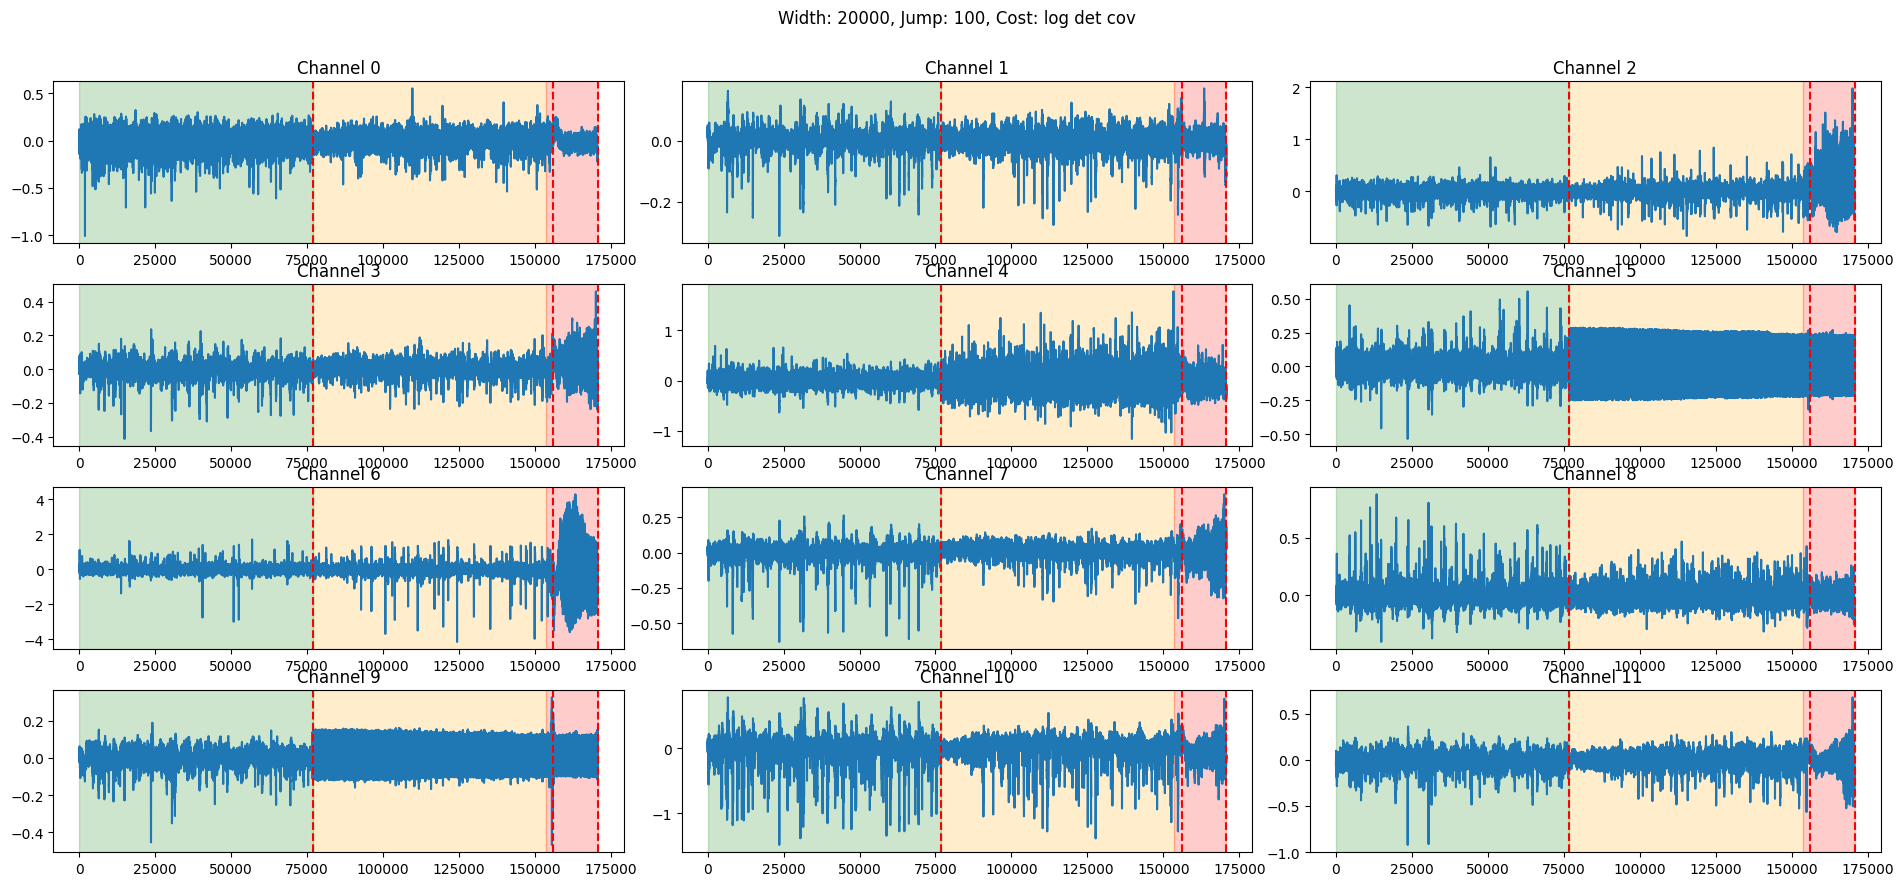

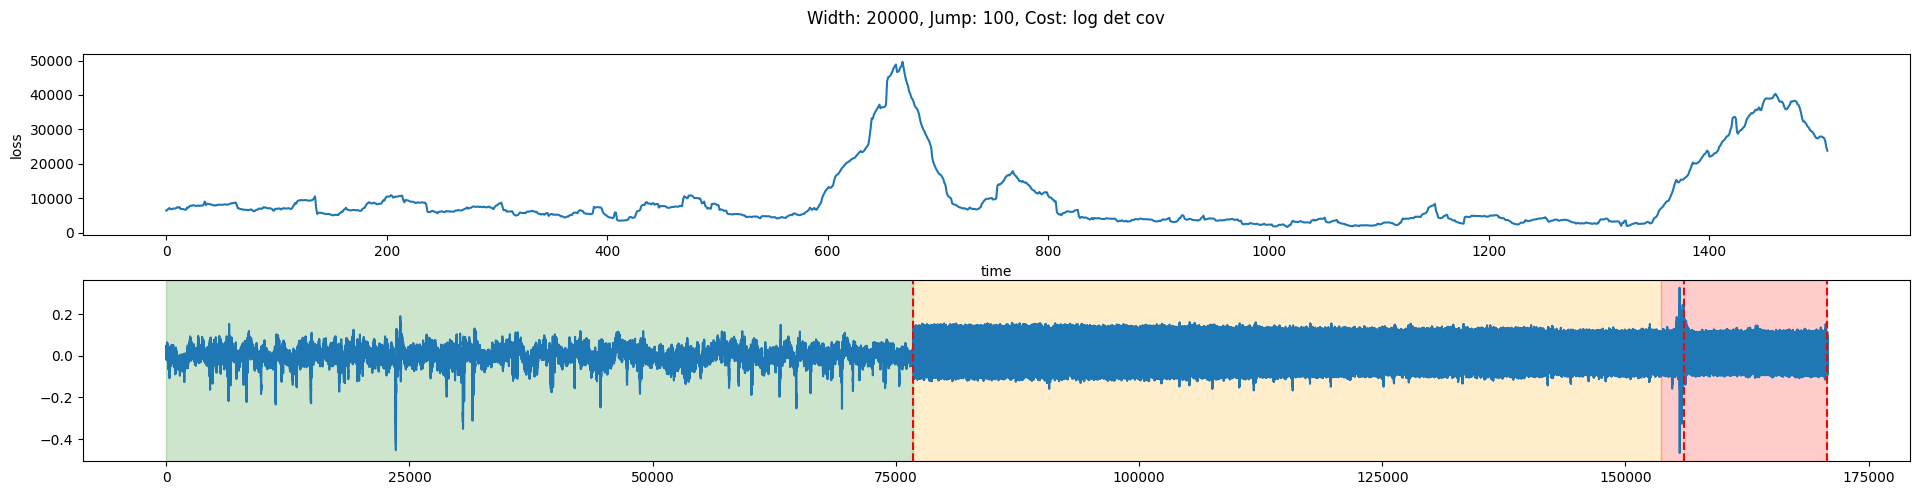

Prediction: [76800, 156000, 170752], Ground truth: [76800, 153600, 170752]
Average_percision: 0.5
ARL: 0, EDD: 2400.0


In [ ]:
detect_draw(EEG, [76800, 76800 * 2, 170752],  model='normal', width=20000)

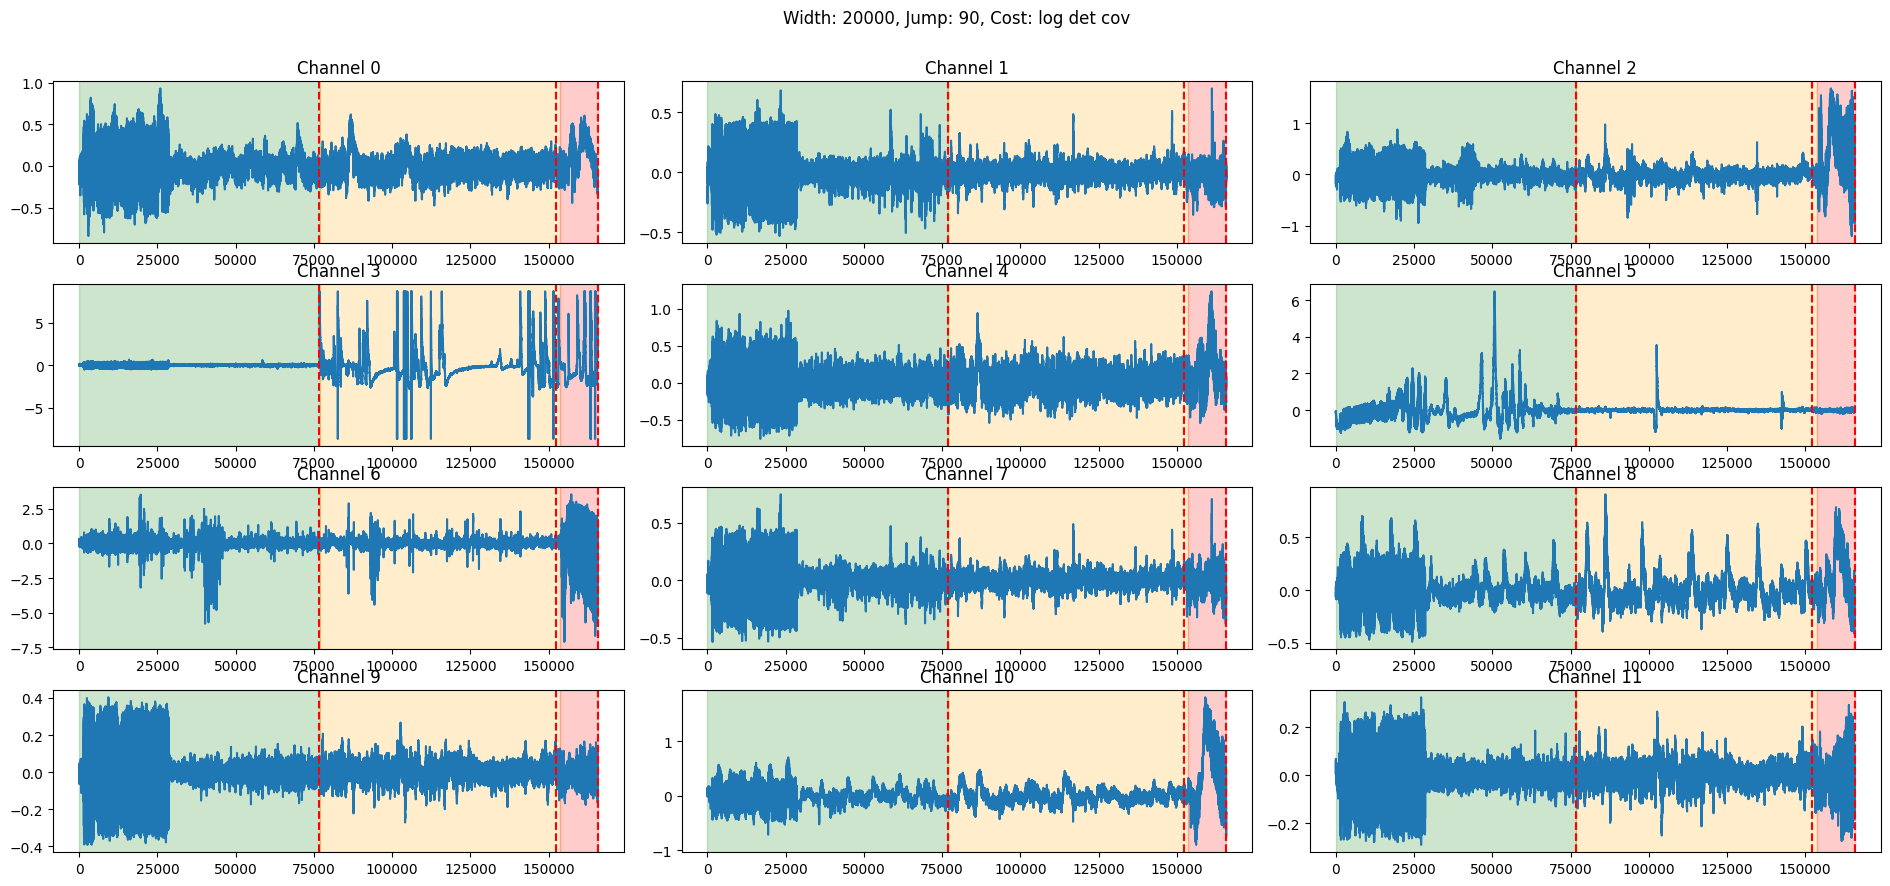

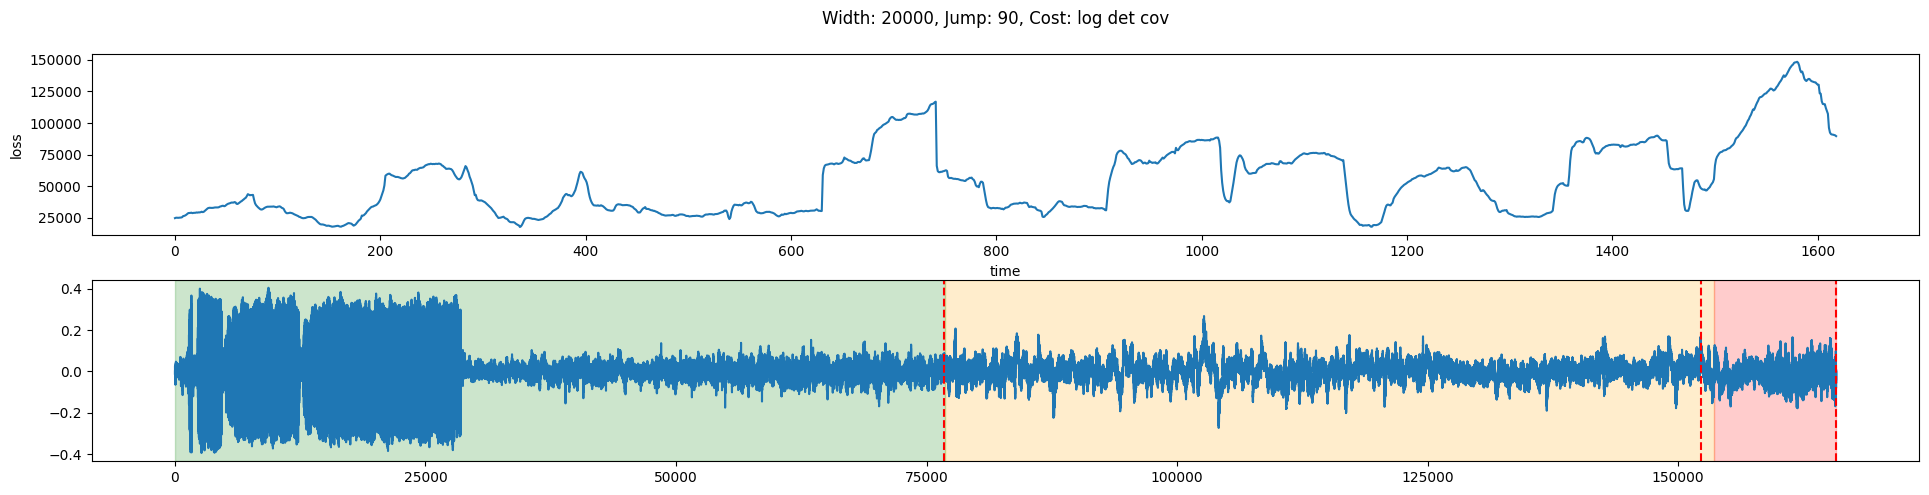

Prediction: [76770, 152280, 165760], Ground truth: [76800, 153600, 165760]
Average_percision: 1.0
ARL: -675.0, EDD: 0


In [ ]:
detect_draw(EEG2, [76800, 153600, 165760], width=20000, jump=90, n_bkps=2)

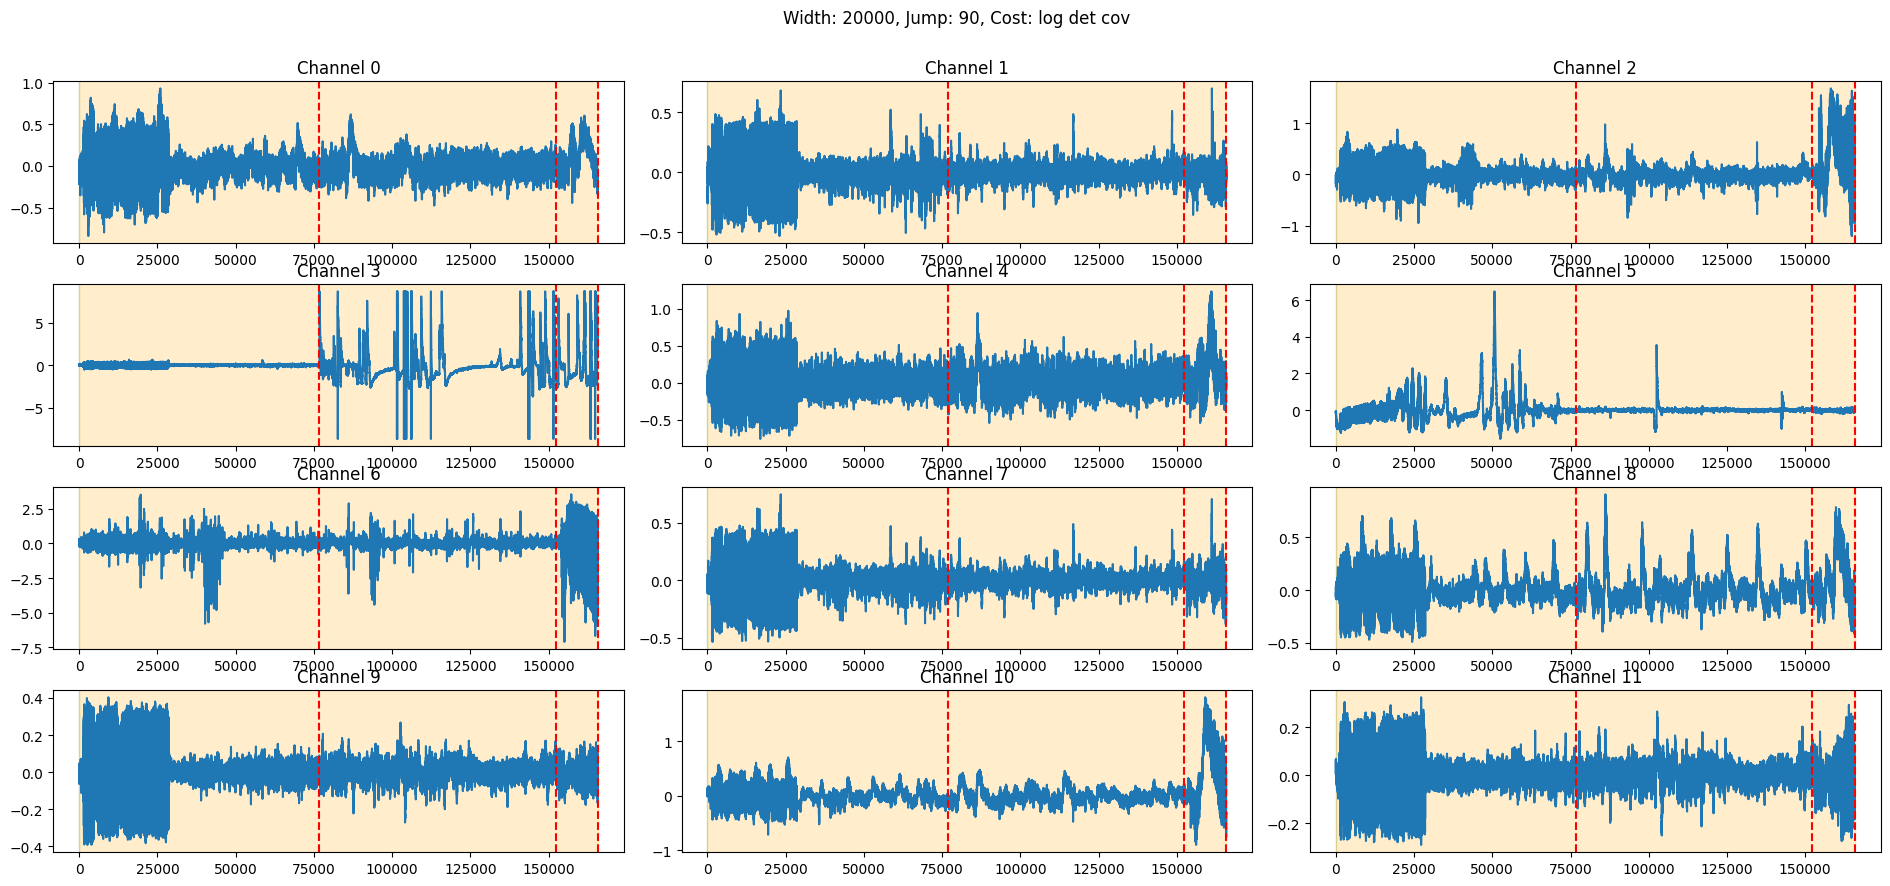

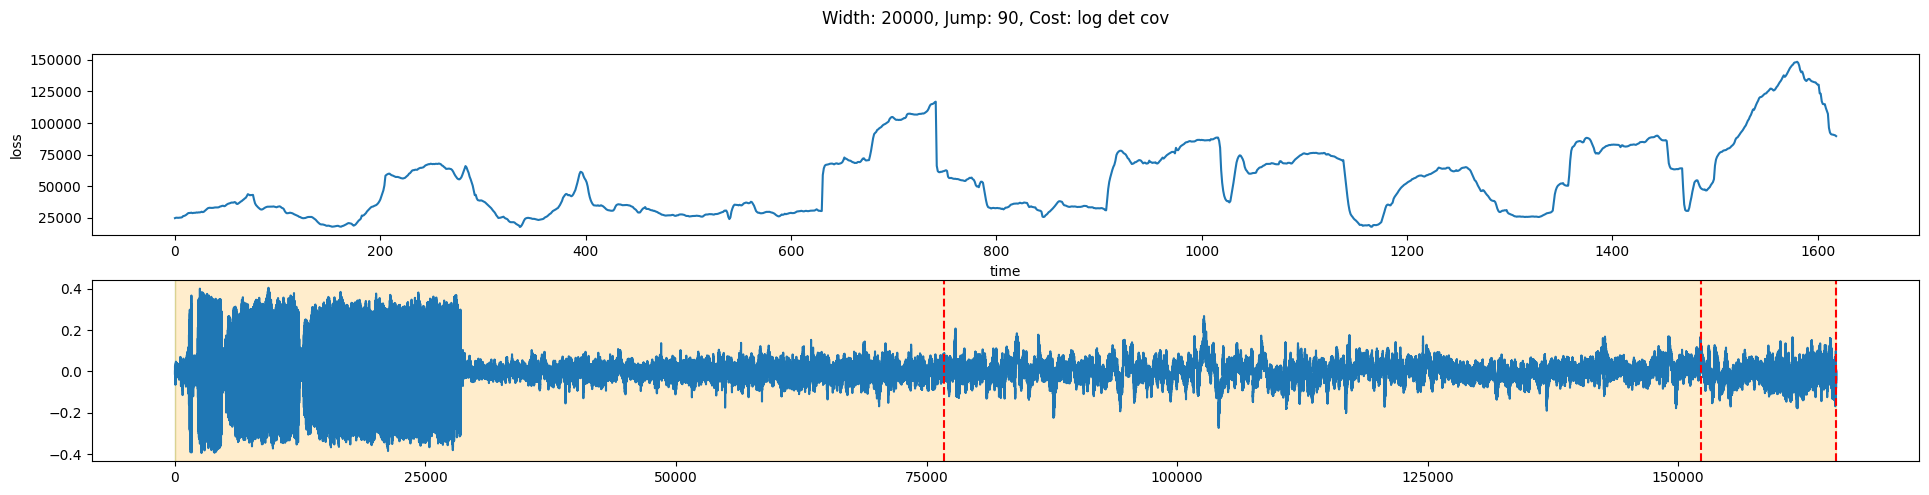

Prediction: [76770, 152280, 165760], Ground truth: [0, 165760]
Average_percision: 0.0
ARL: 0, EDD: 76770.0


In [ ]:
detect_draw(NewTest1, [0, 165760], width=20000, jump=90, n_bkps=2)

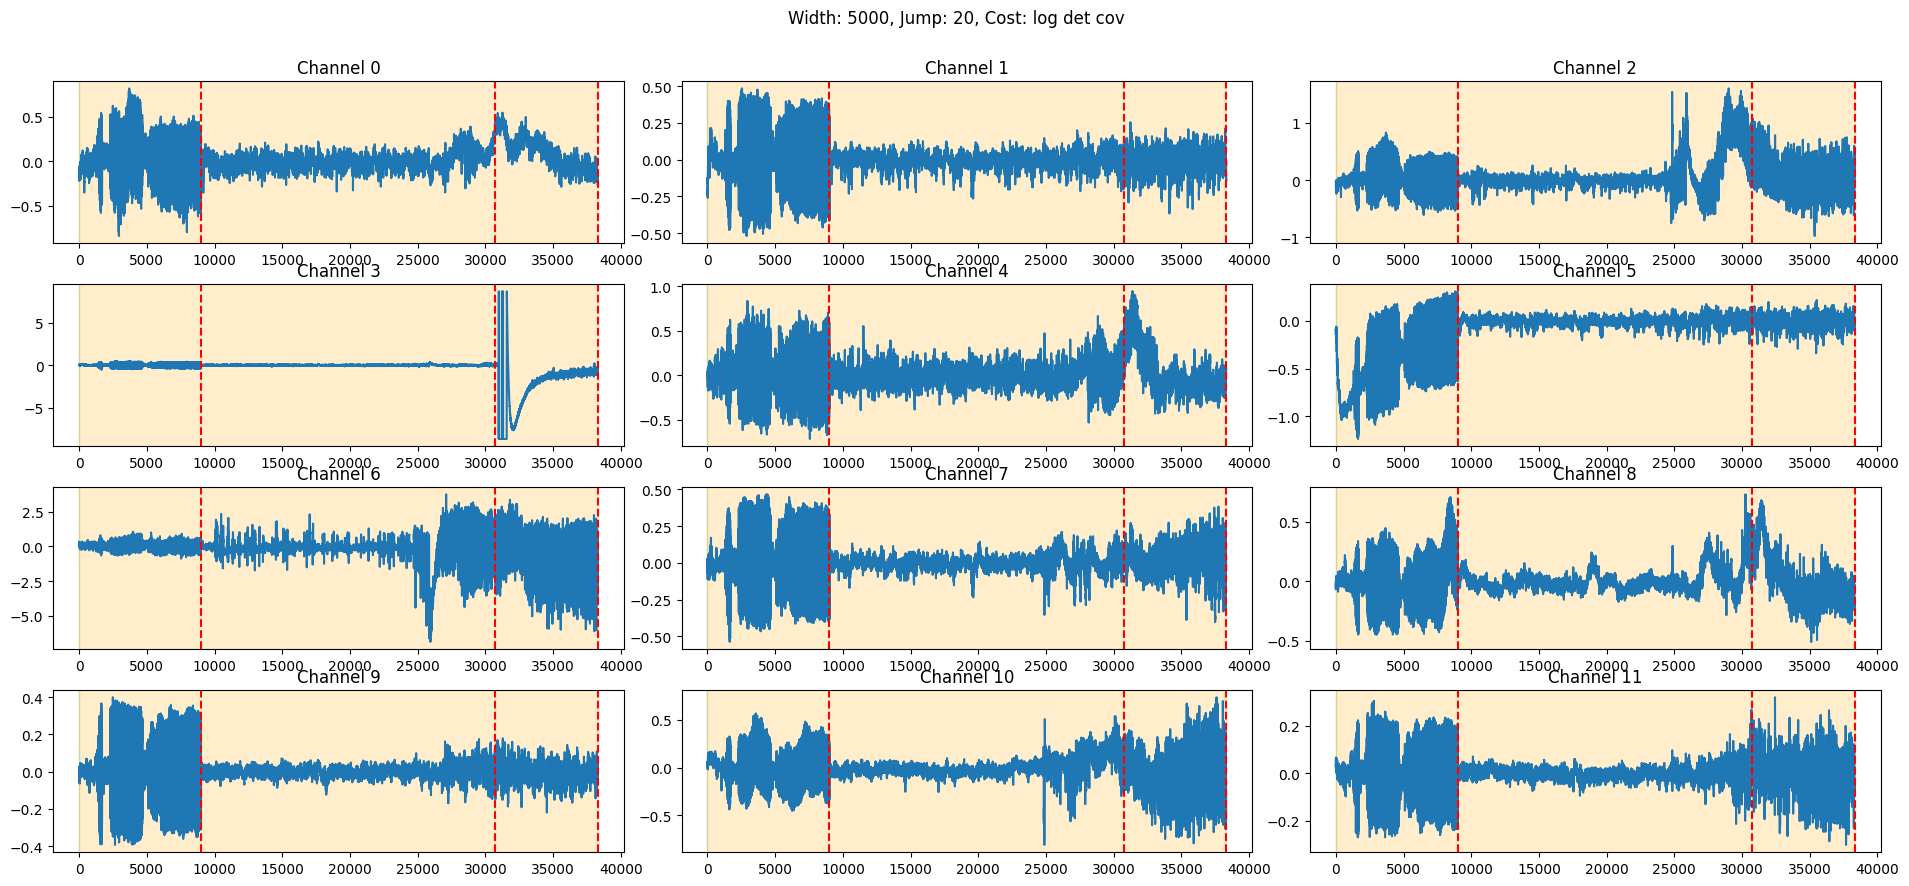

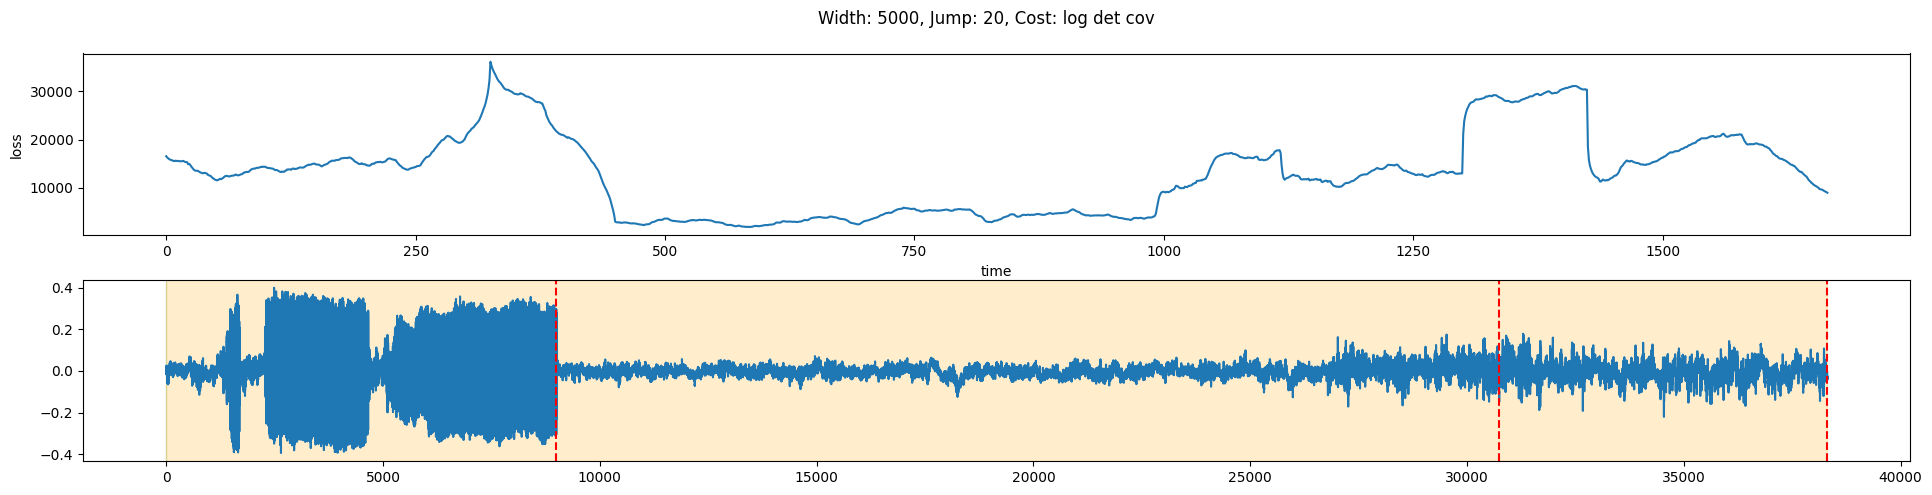

Prediction: [9000, 30740, 38312], Ground truth: [0, 38312]
Average_percision: 0.0
ARL: 0, EDD: 9000.0


In [ ]:
detect_draw(NewTest2, [0, 38312], width=5000, jump=20, n_bkps=2)

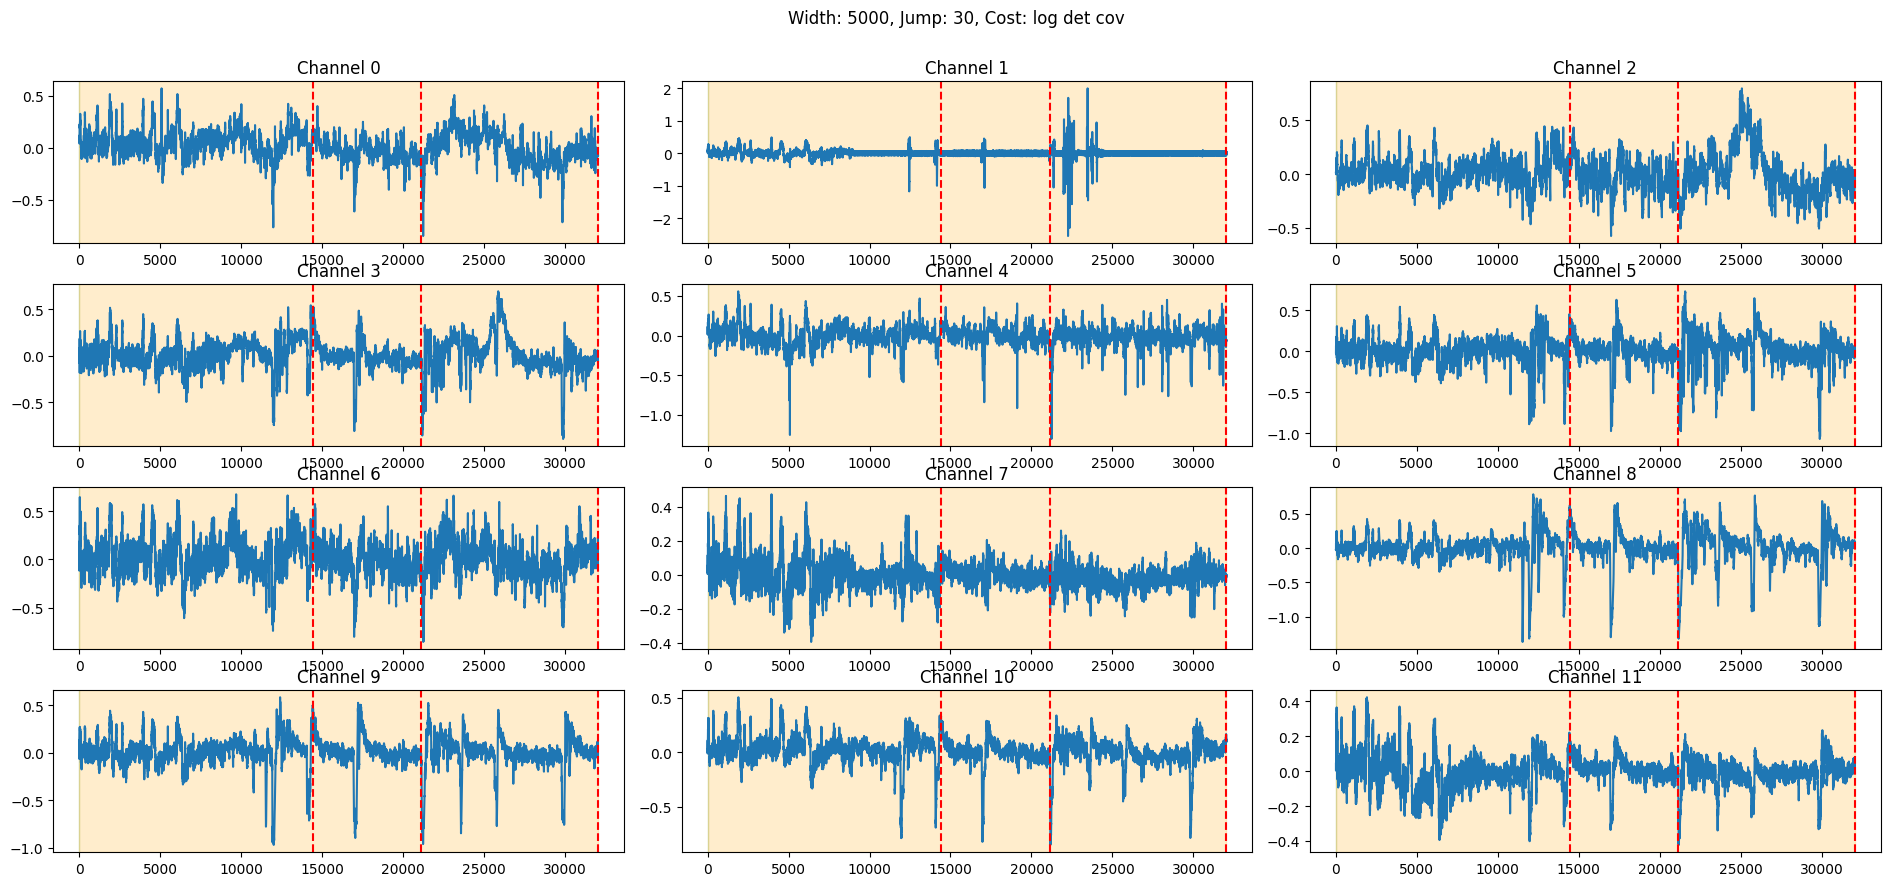

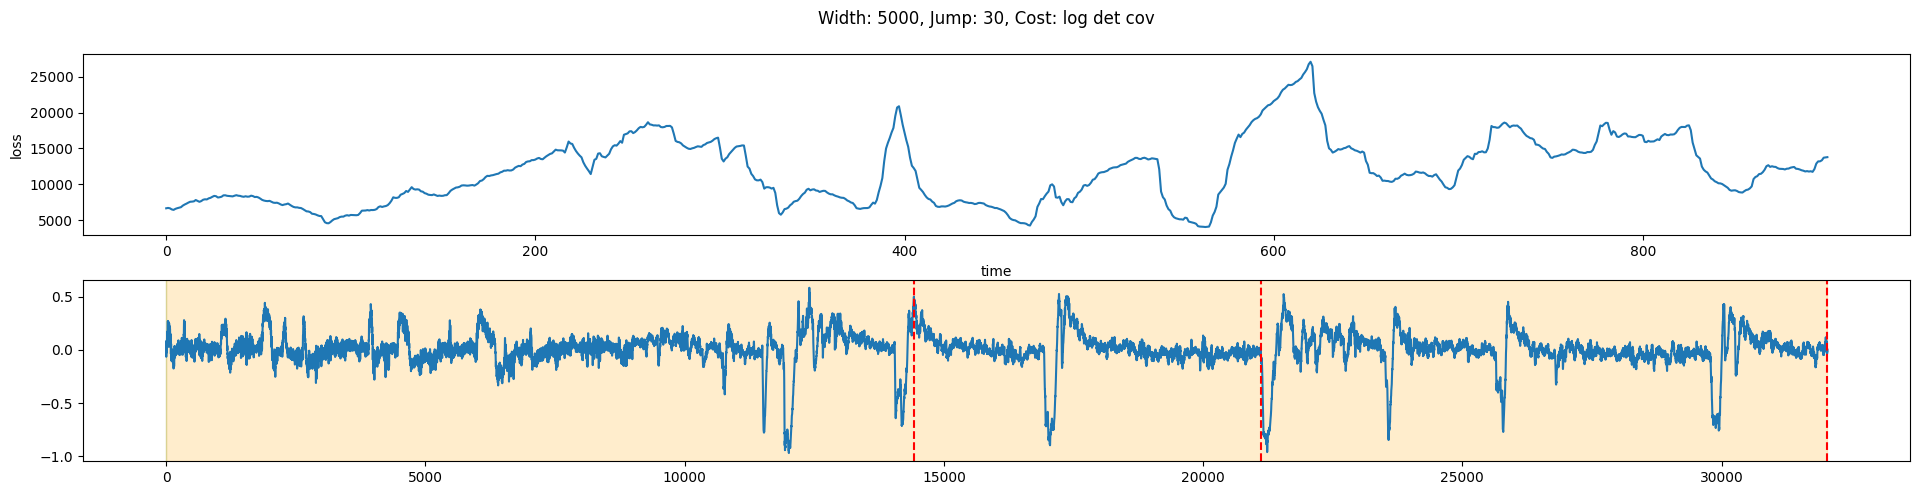

Prediction: [14430, 21120, 32040], Ground truth: [0, 32040]
Average_percision: 0.0
ARL: 0, EDD: 14430.0


In [ ]:
detect_draw(NewTest3, [0, 32040], width=5000, jump=30)

[3701, 4714, 5425, 9819]


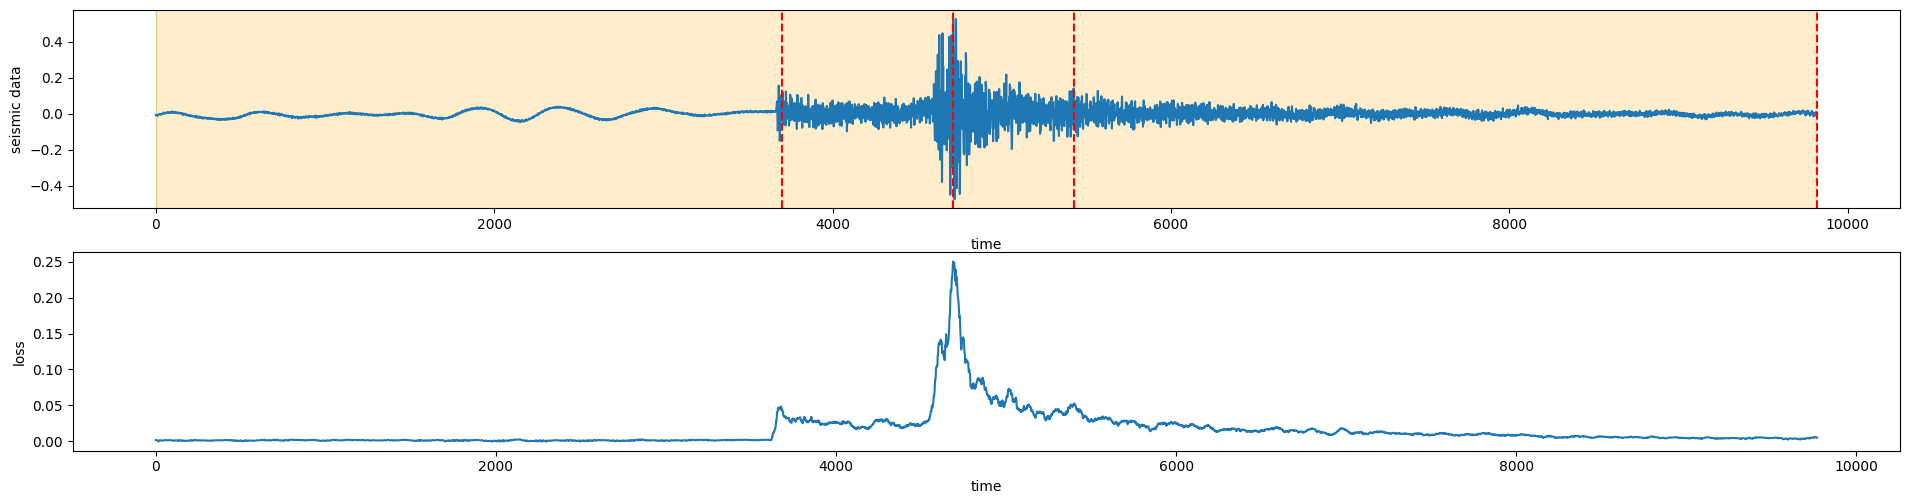

In [ ]:
detect_draw_one_channel(Test2, [0, 9819], margin=200, width=50, jump=1)


[2808, 3047, 3481, 8782]


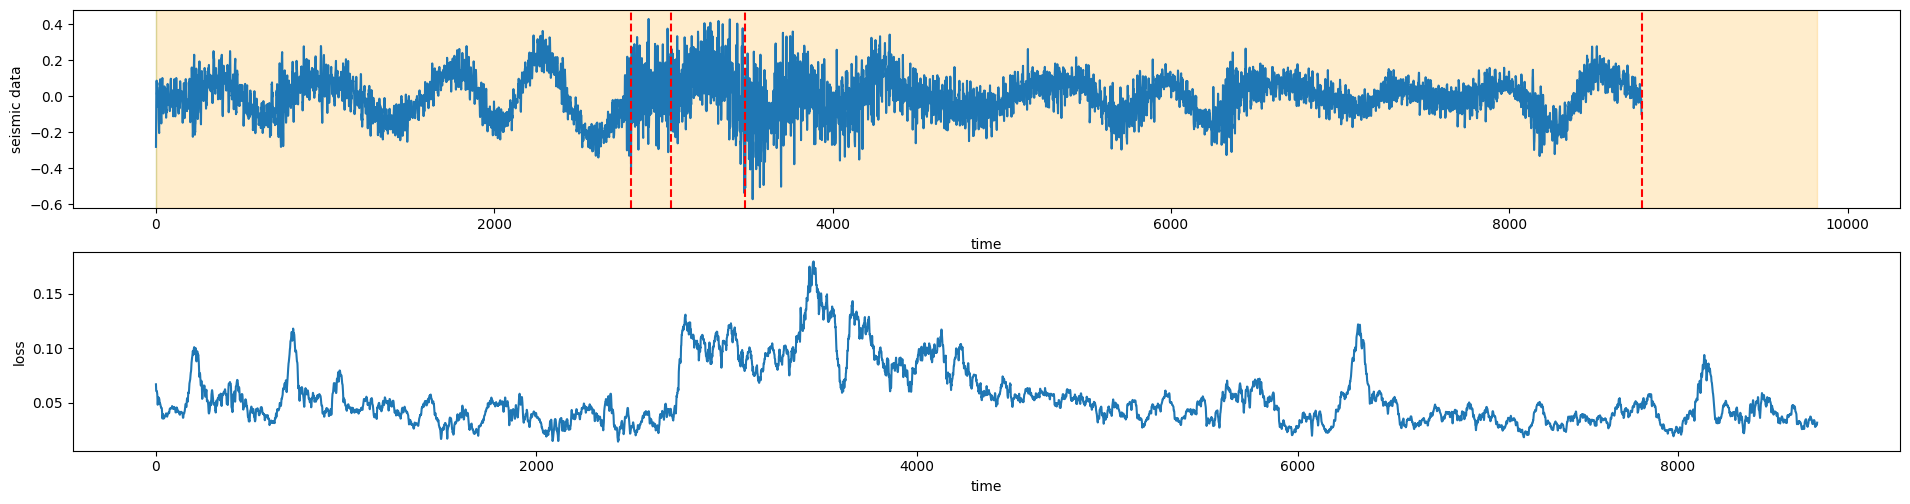

In [ ]:
detect_draw_one_channel(Earth2, [0, 9819], margin=200, width=50, jump=1)

[666, 2581, 3109, 8782]


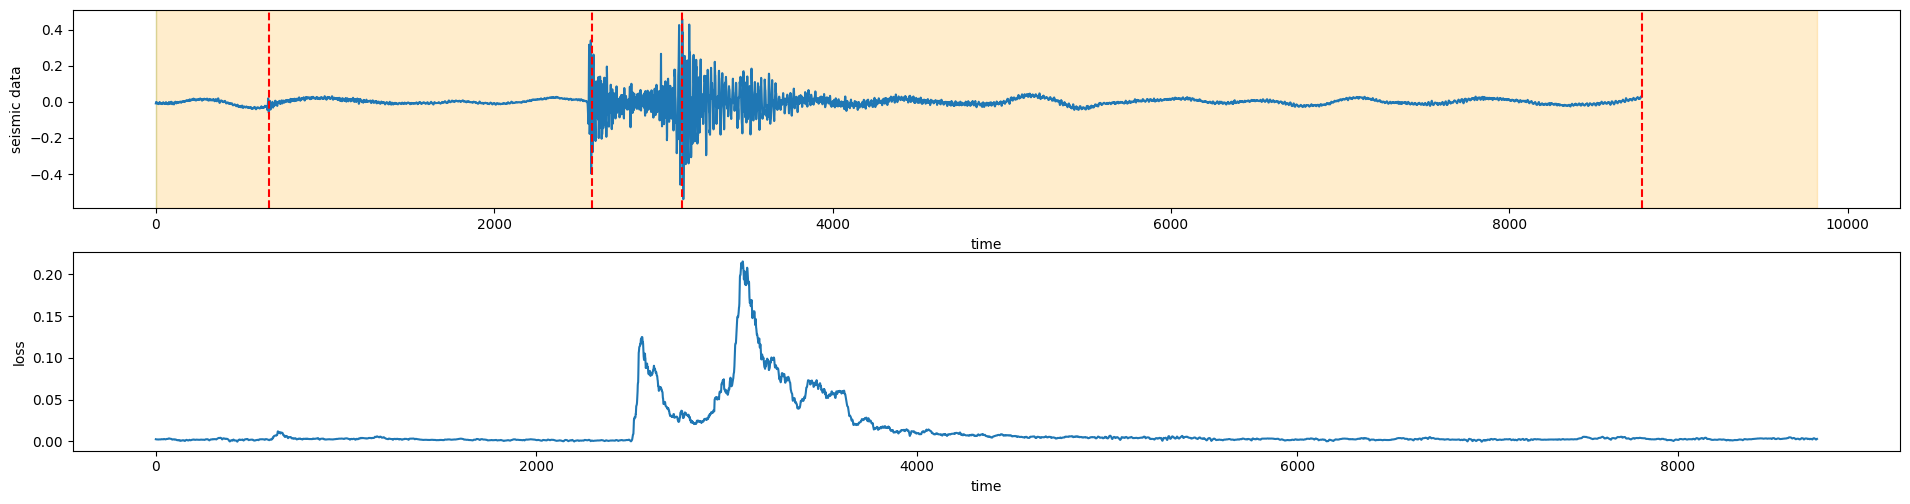

In [ ]:
detect_draw_one_channel(Earth3, [0, 9819], margin=200, width=50, jump=1)

### Online Detection

Online detection will not use the entire score array to selected the top `n_bkpt` number of breakpoints, instead it will simulated online data and select a breakpoint if the current_score - previous_score is greater than a threshold.

This will lead to the number of predicted breakpoints cannot be predetermined, so there might be more or less prediction than ground truth.

In [ ]:

# Draw the detected chang points and gt region
def detect_draw_online(X, gt_bkps, margin=2000, width=25000, jump=100, model='normal', n_bkps=2, threshold=20000):
    num_channels = X.shape[0]
    result, score = detect_online(X, gt_bkps, width, jump, model, 2, threshold)

    fig, axes = plt.subplots(num_channels // 3 + num_channels % 3, 3, figsize=(19, 9))
    plt.tight_layout()
    if model == 'normal': model = 'log det cov'
    fig.suptitle(f"Width: {width}, Jump: {jump}, Cost: {model}")
    fig.subplots_adjust(top=0.9)

    for i in range(num_channels):
        ax = axes.flat[i]
        draw(X[i], result, gt_bkps, ax)
        ax.set_title(f'Channel {i}')


def detect_online(X, gt_bkps, width, jump, model, n_bkps, threshold):
    algo = rpt.Window(width=width, model=model, jump=jump, min_size=1000).fit(X.T)
    # result will not be used because it is online detection
    _ = algo.predict(n_bkps=n_bkps)
    scores = algo.score

    change_points = []
    prev_score = float('inf')

    for i, score in enumerate(scores):
        # Check for big change in score compared to previous value
        if abs(score - prev_score) >= threshold:
            change_points.append(i * jump)
            prev_score = score
    print(change_points)
    return change_points, scores


# special case for one channel
def detect_draw_one_channel_online(X, gt_bkps, margin=200, width=100, jump=10, threshold=5000):
    X = (X - np.min(X)) / ( np.max(X) - np.min(X))
    X -= np.average(X)


    algo = rpt.Window(width=width, custom_cost=CombinedCost(), jump=jump, min_size=200).fit(X.T)
    _ = algo.predict(n_bkps=3)

    scores = algo.score

    change_points = []
    prev_score = float('inf')

    for i, score in enumerate(scores):
        # Check for big change in score compared to previous value
        if abs(score - prev_score) >= threshold:
            change_points.append(i * jump)
            prev_score = score

    print(change_points)

    fig, axes = plt.subplots(1, 1, figsize=(19, 5))

    draw(X, change_points, gt_bkps, axes)



### Online Detection Result

/usr/local/lib/python3.10/dist-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


[0, 64600, 80800, 144500]


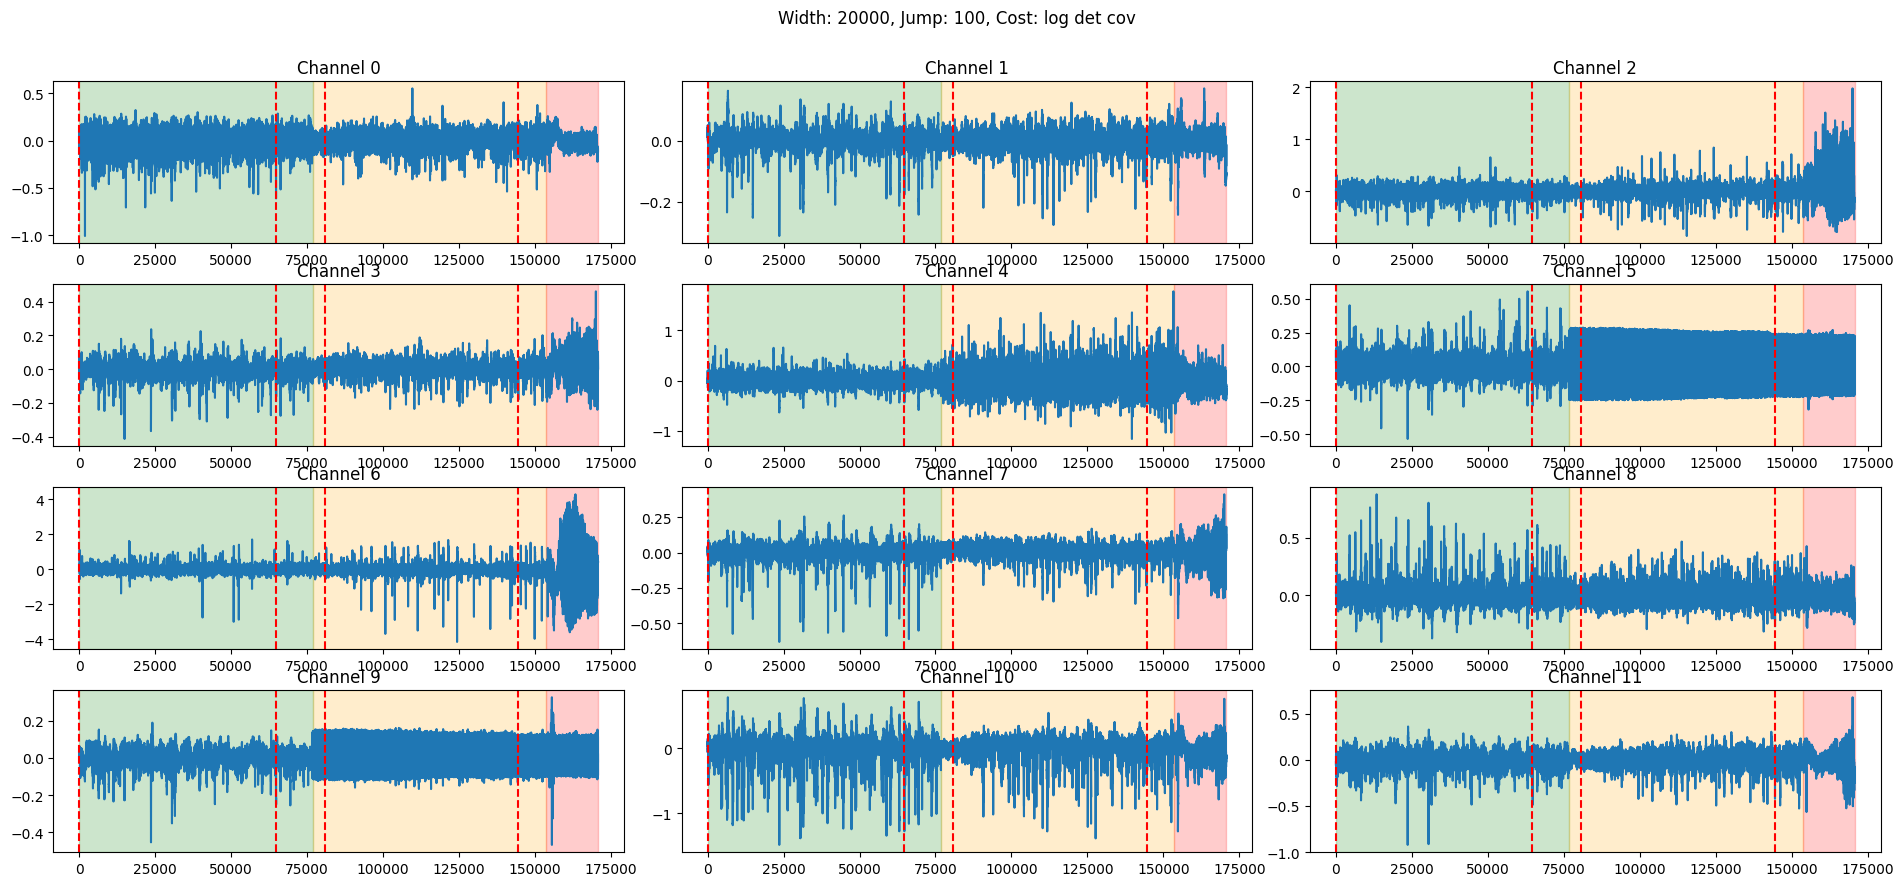

In [ ]:
detect_draw_online(EEG, [76800, 76800 * 2, 170752],  model='normal', width=20000, threshold=30000)

[0, 66100, 103400, 138400]


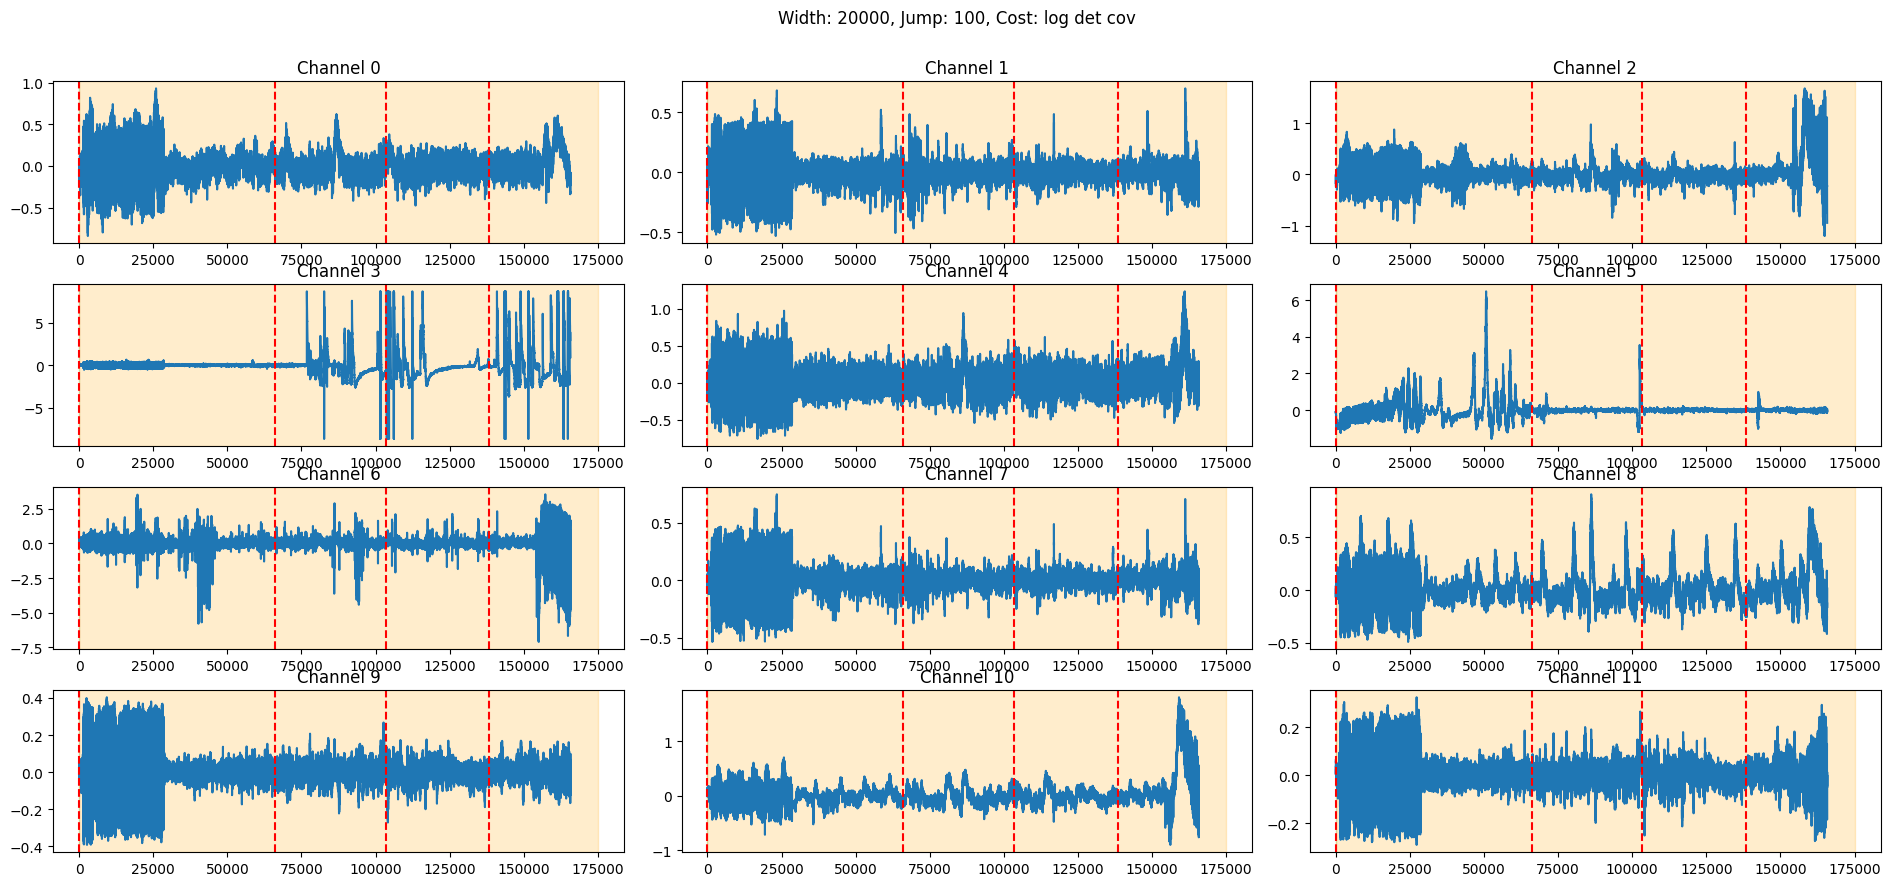

In [ ]:
detect_draw_online(EEG2, [0, 175000],  model='normal', width=20000, threshold=85000)

/usr/local/lib/python3.10/dist-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


[0, 61020, 103420, 122440, 139720]


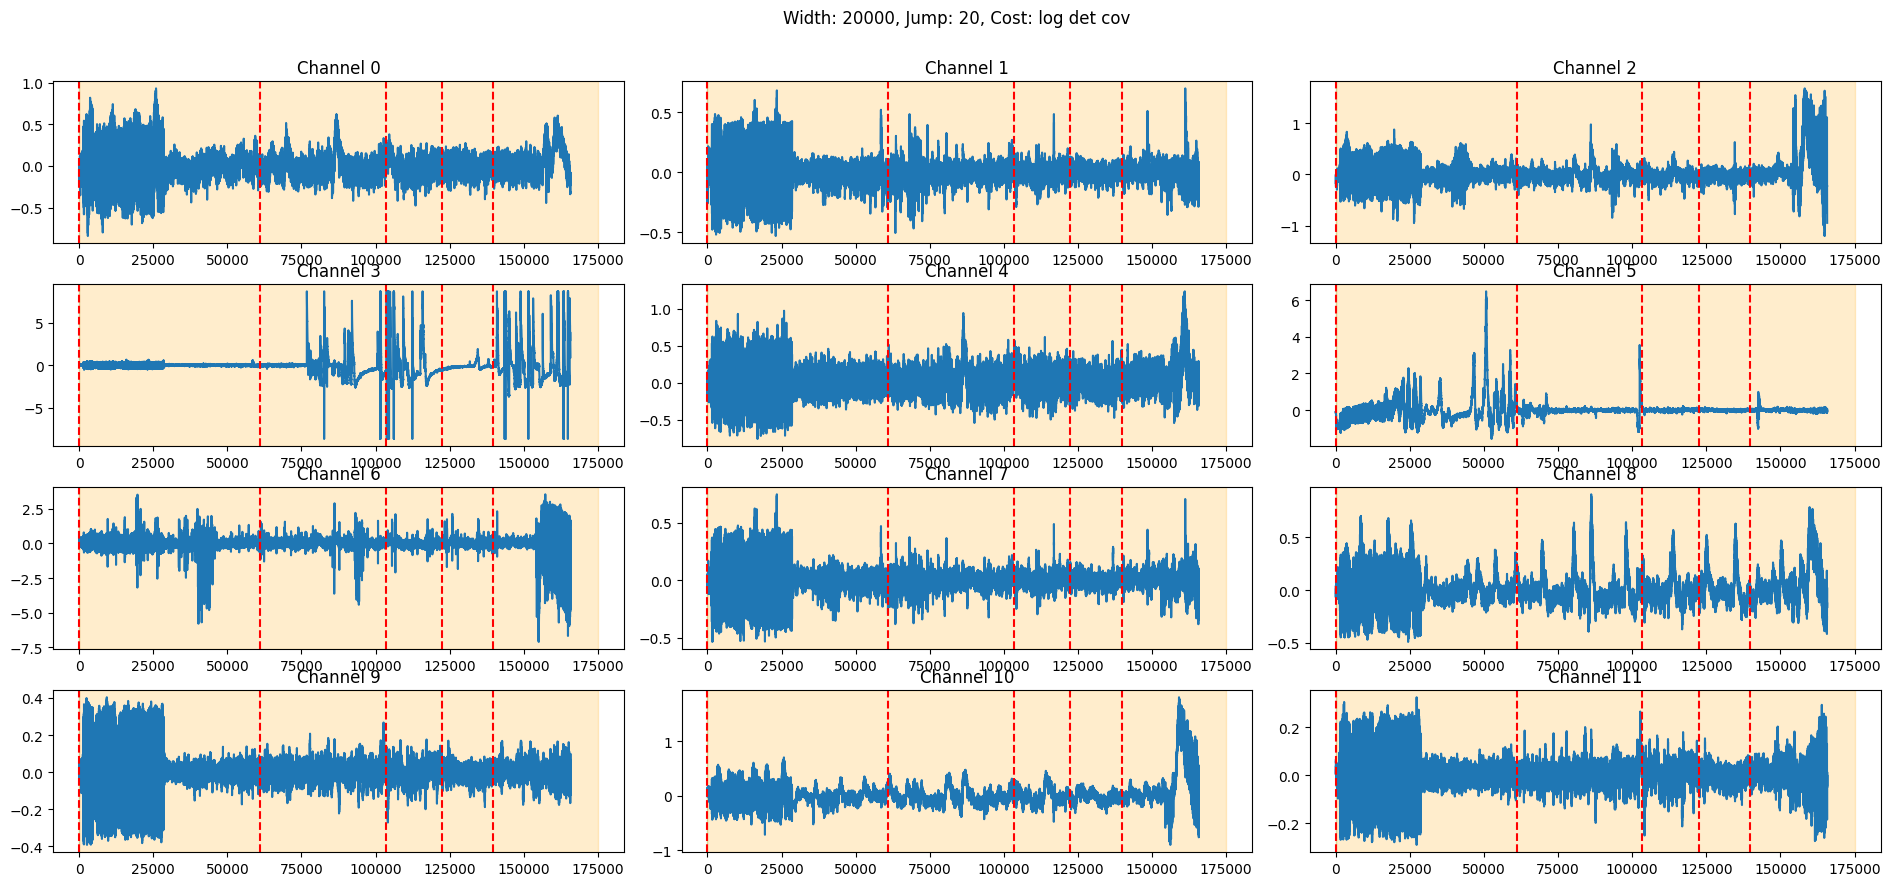

In [ ]:
detect_draw_online(NewTest1, [0, 175000], width=20000, jump=20, threshold=50000)


[0, 6380, 8460, 8940, 21040, 26080, 28520]


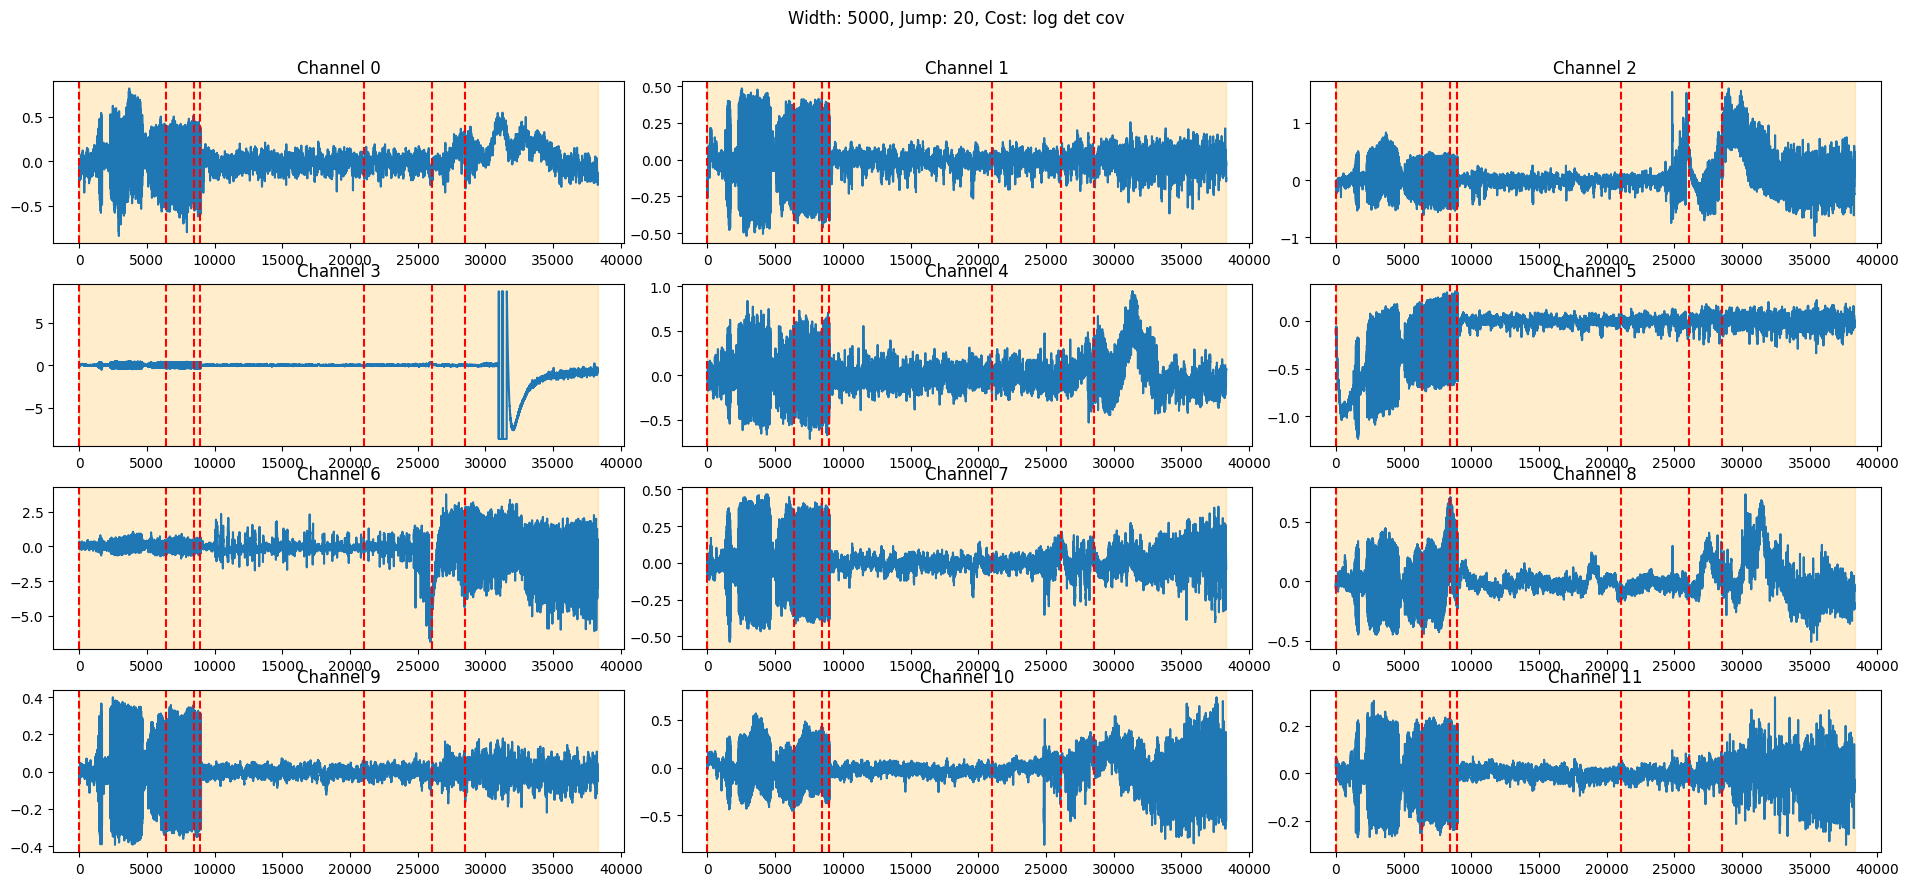

In [ ]:
detect_draw_online(NewTest2, [0, 38312], width=5000, jump=20, threshold=10000)

[0, 18600]


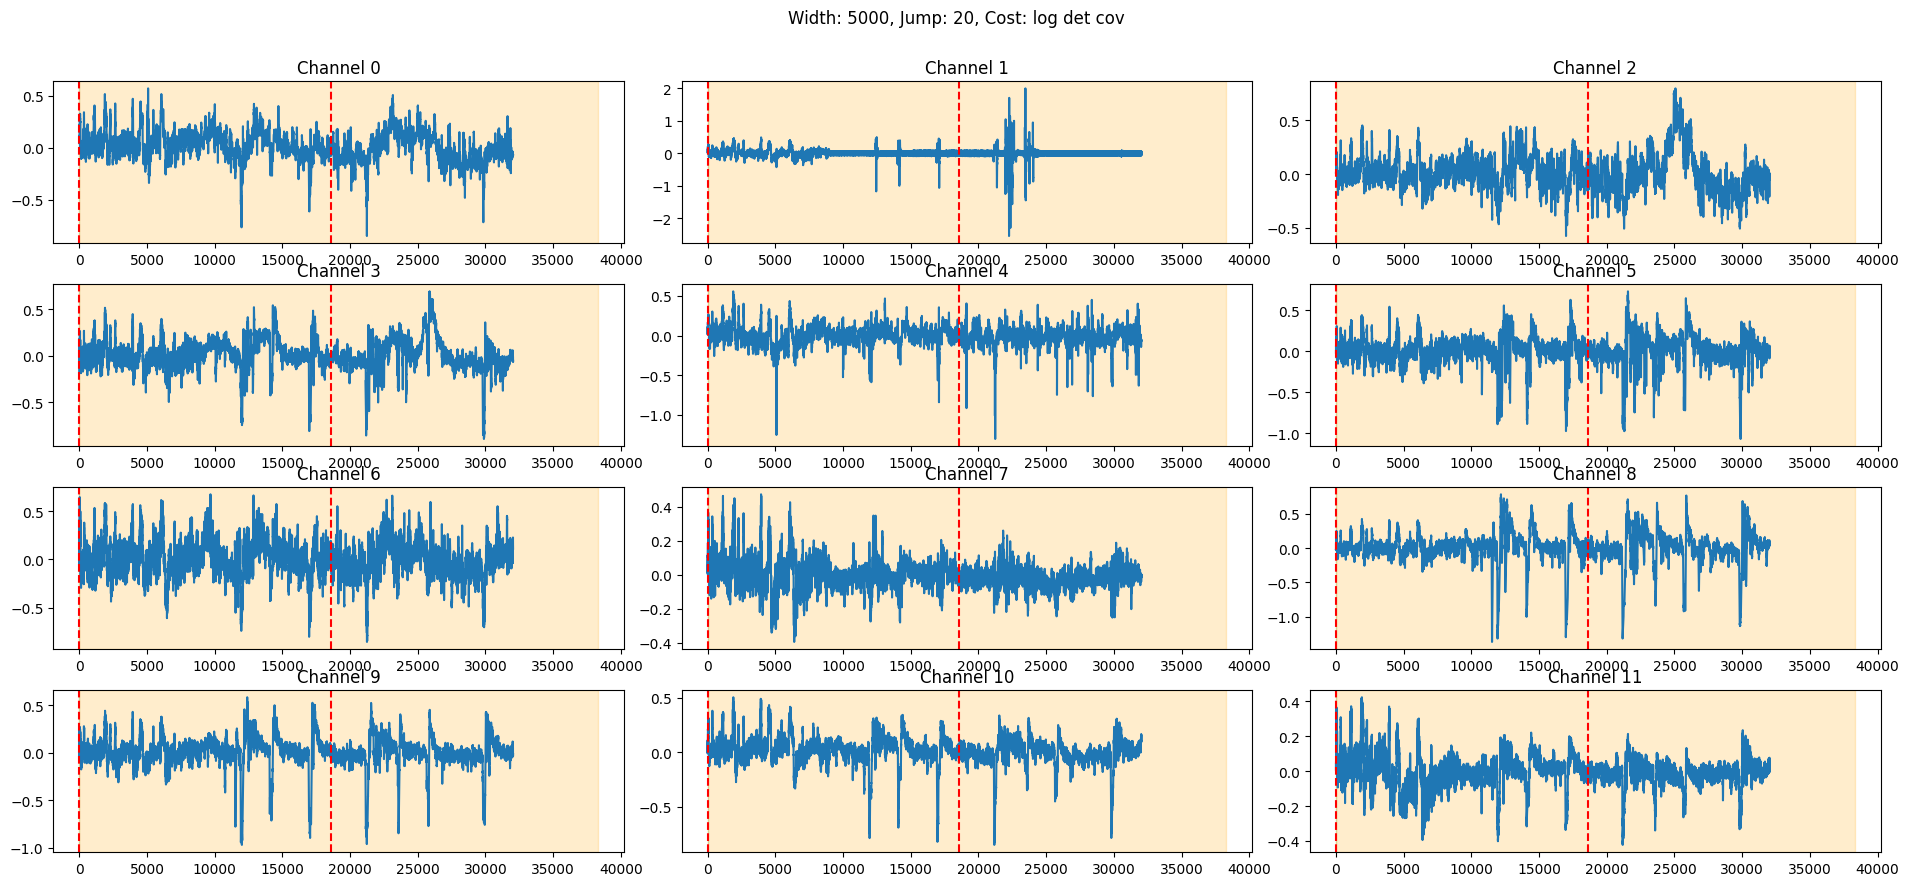

In [ ]:
detect_draw_online(NewTest3, [0, 38312], width=5000, jump=20, threshold=20000)


[0, 3657, 4582, 4601, 4667, 4679, 4724, 4734, 4786, 4910, 6235]


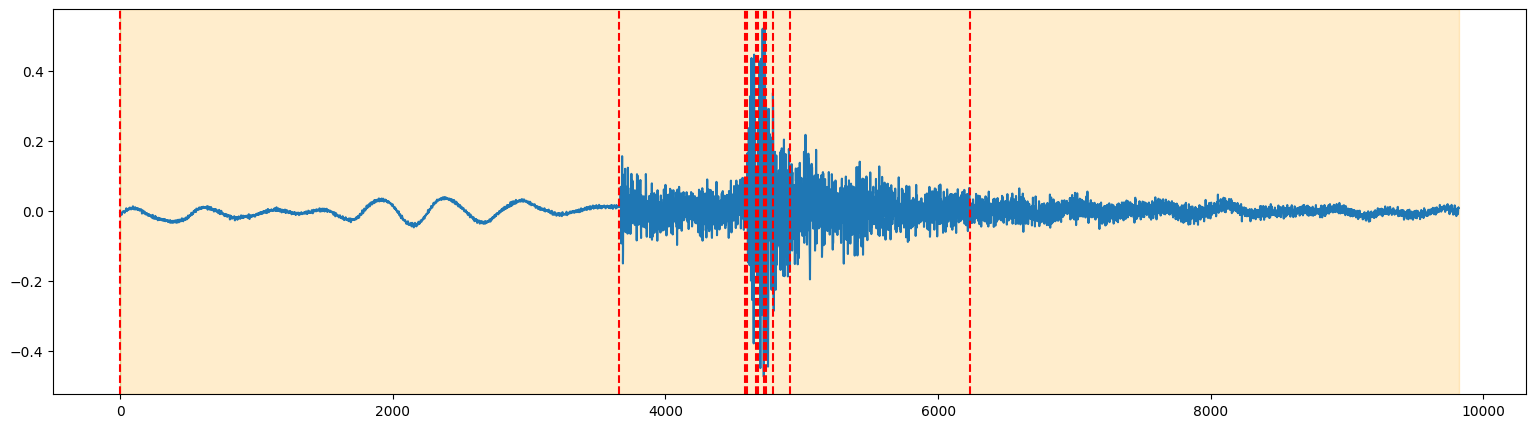

In [ ]:
detect_draw_one_channel_online(Test2, [0, 9819], margin=200, width=50, jump=1, threshold=.04)


[0, 3434, 3594]


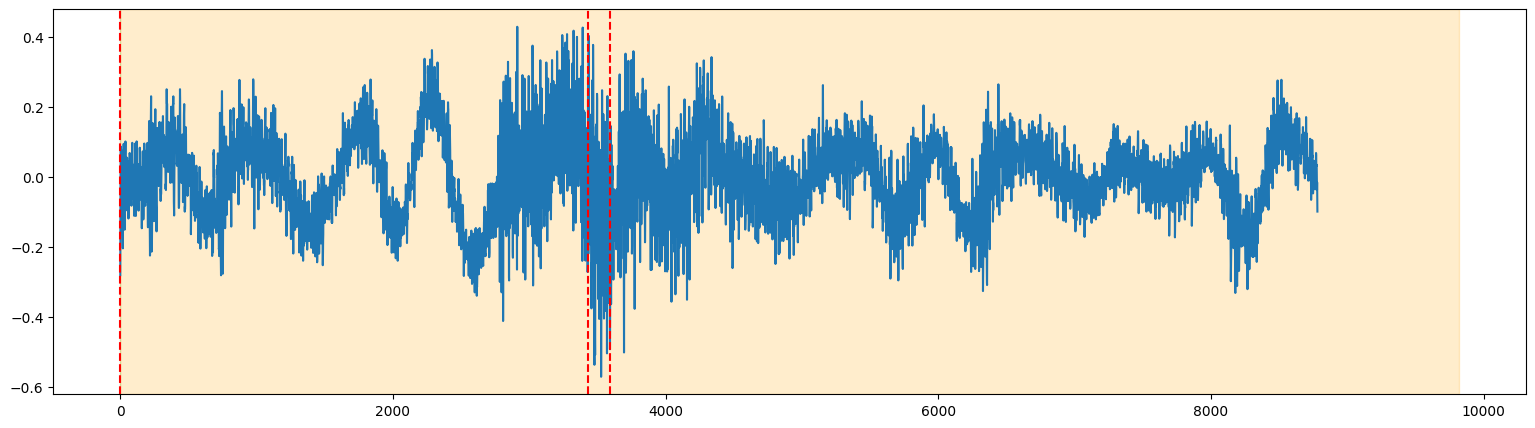

In [ ]:
detect_draw_one_channel_online(Earth2, [0, 9819], margin=200, width=50, jump=1, threshold=.1)


[0, 2538, 3075, 3180, 3962]


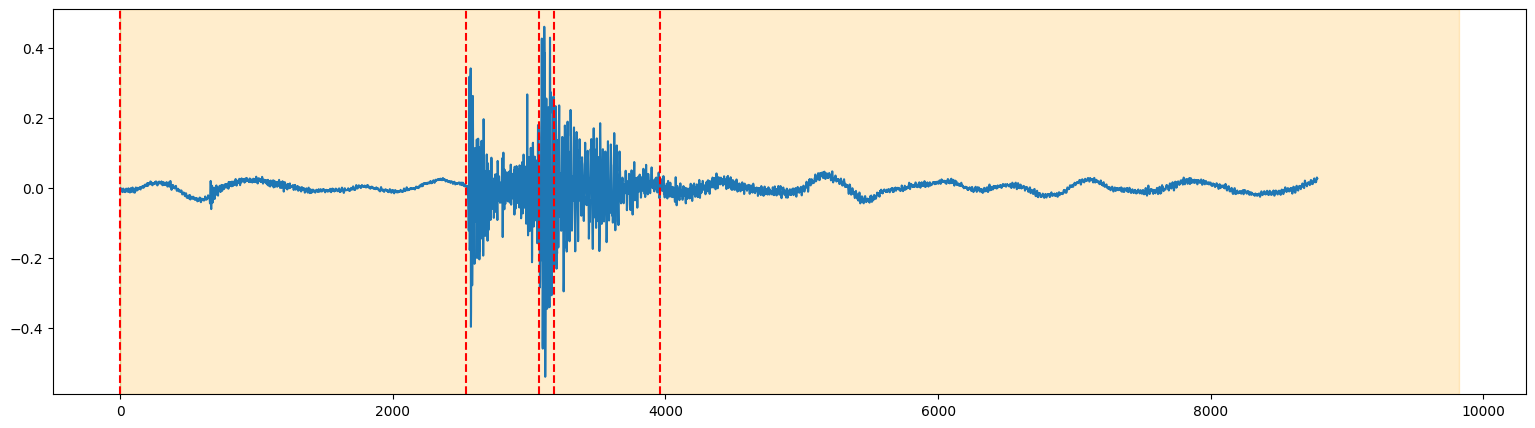

In [ ]:
detect_draw_one_channel_online(Earth3, [0, 9819], margin=200, width=50, jump=1, threshold=.1)